**This notebook is an exercise in the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/principal-component-analysis).**

---


# Introduction #

In this exercise, you'll work through several applications of PCA to the [*Ames*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset.

Run this cell to set everything up!

In [1]:
# 引入所需库和模块
from learntools.core import binder
binder.bind(globals())
from learntools.feature_engineering_new.ex5 import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# 设置 Matplotlib 的默认样式
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# 定义应用主成分分析（PCA）的函数
def apply_pca(X, standardize=True):
    # 标准化数据
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # 创建主成分
    pca = PCA() 
    # 通过找到数据中的主要变化方向来减少数据的维数，同时保留最重要的信息。 
    # 使用[[奇异值分解（SVD）]]将数据投影到低维空间。 
    # 数据会被居中（减去均值）但不会被缩放。
    
    X_pca = pca.fit_transform(X)
    # 转换为 DataFrame
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # 创建载荷矩阵
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

# 定义绘制方差解释图的函数
def plot_variance(pca, width=8, dpi=100):
    # 创建图形
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # 解释方差
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # 累积方差
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # 设置图形属性
    fig.set(figwidth=8, dpi=100)
    return axs

# 定义计算互信息分数的函数
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # 所有离散特征现在应该具有整数数据类型
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# 定义评估数据集得分的函数
def score_dataset(X, y, model=XGBRegressor()):
    # 类别特征的标签编码
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # 房屋竞赛的指标是RMSLE（均方根对数误差）
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

# 读取数据集
df = pd.read_csv("../input/fe-course-data/ames.csv")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_1228/4241426366.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Let's choose a few features that are highly correlated with our target, `SalePrice`.


In [2]:
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

print("Correlation with SalePrice:\n")
print(df[features].corrwith(df.SalePrice))

Correlation with SalePrice:

GarageArea      0.640138
YearRemodAdd    0.532974
TotalBsmtSF     0.632529
GrLivArea       0.706780
dtype: float64


Pandas的corrwith()函数用于计算DataFrame中的行或列与另一个Series或DataFrame的相关性。这是通过计算配对观察值之间的相关系数来实现的。实现原理主要涉及以下几个步骤：

对齐输入：如果你与另一个DataFrame进行比较，corrwith()会确保行或列（取决于你选择的轴）在两个DataFrame之间对齐。这意味着它会按照索引（行比较）或列名（列比较）匹配配对的元素。

删除缺失值：由于相关性需要配对的观察值，所以任何缺失值都将从计算中排除。

计算相关性：对于每个配对的行或列，corrwith()计算相关系数。默认情况下，使用皮尔逊相关系数，但你可以通过method参数选择其他相关系数（如斯皮尔曼或肯德尔）。

返回结果：返回一个Series，其中包含与输入DataFrame的每个行或列的相关性结果。


总体而言，corrwith()函数的实现原理是通过配对观察值计算相关性，确保正确的对齐并处理任何缺失值。

In [3]:
import pandas as pd

df1 = pd.DataFrame({
    'A': [1, 2, 3],
    'B': [4, 5, 6],
    'C': [7, 8, 9]
})

df2 = pd.DataFrame({
    'A': [2, 4, 5],
    'B': [4, 5, 5.9],
    'C': [7.9, 8.6, 10.0]
})

# 计算df1和df2之间的列相关性
correlation = df1.corrwith(df2)
print(correlation)


A    0.981981
B    0.999539
C    0.981981
dtype: float64


We'll rely on PCA to untangle the correlational structure of these features and suggest relationships that might be usefully modeled with new features.

Run this cell to apply PCA and extract the loadings.

我们将依靠 PCA 来理清这些特征的相关结构，并提出可用新特征建模的关系。

运行此单元，应用 PCA 并提取loadings。

                   PC1       PC2       PC3       PC4
GarageArea    0.541229  0.102375 -0.038470  0.833733
YearRemodAdd  0.427077 -0.886612 -0.049062 -0.170639
TotalBsmtSF   0.510076  0.360778 -0.666836 -0.406192
GrLivArea     0.514294  0.270700  0.742592 -0.332837
PC1    0.873029
PC3    0.341337
PC2    0.262388
PC4    0.087857
Name: MI Scores, dtype: float64


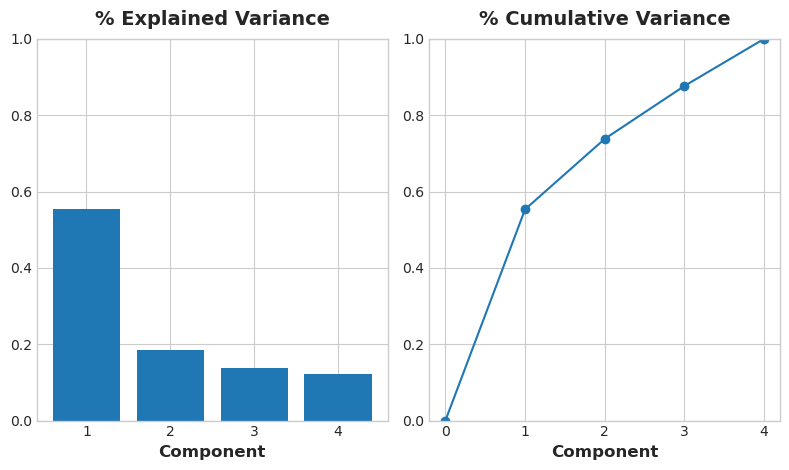

In [4]:
X = df.copy()
y = X.pop("SalePrice")
X = X.loc[:, features]

# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X)
print(loadings)

# Look at explained variance
plot_variance(pca);

mi_scores = make_mi_scores(X_pca, y)
print(mi_scores)

```python
def apply_pca(X, standardize=True):
    # 如果 standardize 为 True，则进行标准化
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # 创建 PCA 对象
    pca = PCA()
    # 对数据 X 进行 PCA 转换,并且将其作为新特征输出
    X_pca = pca.fit_transform(X)
    # 将主成分名称转换为 PC1、PC2 等
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    # 将转换后的数据转换为 DataFrame，并使用主成分名称作为列名
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # 创建载荷矩阵
    loadings = pd.DataFrame(
        pca.components_.T,  # 转置载荷矩阵
        columns=component_names,  # 列名为主成分
        index=X.columns,  # 行名为原始特征
    )
    # 返回 PCA 对象、转换后的数据和载荷矩阵
    return pca, X_pca, loadings
```
这个函数执行主成分分析（PCA）并返回PCA对象、转换后的数据和载荷矩阵。如果standardize参数为True（默认），则在执行PCA之前将数据标准化。

# 1) Interpret Component Loadings

Look at the loadings for components `PC1` and `PC3`. Can you think of a description of what kind of contrast each component has captured? After you've thought about it, run the next cell for a solution.

1) 解释成分载荷
查看成分 PC1 和 PC3 的载荷。你能想出每个分量捕捉到了什么样的对比吗？想好后，运行下一个单元格求解。

In [5]:
# View the solution (Run this cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The first component, `PC1`, seems to be a kind of "size" component, similar to what we saw in the tutorial: all of the features have the same sign (positive), indicating that this component is describing a contrast between houses having large values and houses having small values for these features.

The interpretation of the third component `PC3` is a little trickier. The features `GarageArea` and `YearRemodAdd` both have near-zero loadings, so let's ignore those. This component is mostly about `TotalBsmtSF` and `GrLivArea`. It describes a contrast between houses with a lot of living area but small (or non-existant) basements, and the opposite: small houses with large basements.


第一个分量 PC1 似乎是一种 "大小 "分量，与我们在教程中看到的类似：所有特征都具有相同的符号（正），表明该分量描述的是这些特征值大的房屋与这些特征值小的房屋之间的对比。

第三个分量 PC3 的解释比较复杂。GarageArea 和 YearRemodAdd 这两个特征的载荷都接近于零，因此我们忽略它们。这个分量主要与 TotalBsmtSF 和 GrLivArea 有关。它描述了居住面积大但地下室小（或没有）的房屋与相反的情况：地下室大但房屋小。

```
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]
df.loc[idx, cols]
df["sports_or_wagon"] = X.TotalBsmtSF / X.GrLivArea
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);
```

-------------------------------------------------------------------------------

Your goal in this question is to use the results of PCA to discover one or more new features that improve the performance of your model. One option is to create features inspired by the loadings, like we did in the tutorial. Another option is to use the components themselves as features (that is, add one or more columns of `X_pca` to `X`).

# 2) Create New Features

Add one or more new features to the dataset `X`. For a correct solution, get a validation score below 0.140 RMSLE. (If you get stuck, feel free to use the `hint` below!)

本问题的目的是利用 PCA 的结果发现一个或多个新特征，从而提高模型的性能。一种方法是根据载荷创建特征，就像我们在教程中所做的那样。

另一种方法是使用成分本身作为特征（即在 X 中添加一列或多列 X_pca）。

2) 创建新特征
在数据集 X 中添加一个或多个新特征。对于正确的解决方案，验证得分应低于 0.140 RMSLE。(如果遇到困难，请随时使用下面的提示！）。

Your score: 0.13361 RMSLE
                            MSSubClass                  MSZoning  LotFrontage  \
0  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density        141.0   
1  One_Story_1946_and_Newer_All_Styles  Residential_High_Density         80.0   
2  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density         81.0   
3  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density         93.0   
4             Two_Story_1946_and_Newer   Residential_Low_Density         74.0   

   LotArea Street            Alley            LotShape LandContour Utilities  \
0  31770.0   Pave  No_Alley_Access  Slightly_Irregular         Lvl    AllPub   
1  11622.0   Pave  No_Alley_Access             Regular         Lvl    AllPub   
2  14267.0   Pave  No_Alley_Access  Slightly_Irregular         Lvl    AllPub   
3  11160.0   Pave  No_Alley_Access             Regular         Lvl    AllPub   
4  13830.0   Pave  No_Alley_Access  Slightly_Irregular         Lvl    AllPub   

  LotC

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Here are two possible solutions, though you might have been able to find others.
```python
# Solution 1: Inspired by loadings
X = df.copy()
y = X.pop("SalePrice")

X["Feature1"] = X.GrLivArea + X.TotalBsmtSF
X["Feature2"] = X.YearRemodAdd * X.TotalBsmtSF

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")


# Solution 2: Uses components
X = df.copy()
y = X.pop("SalePrice")

X = X.join(X_pca)
score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")
```


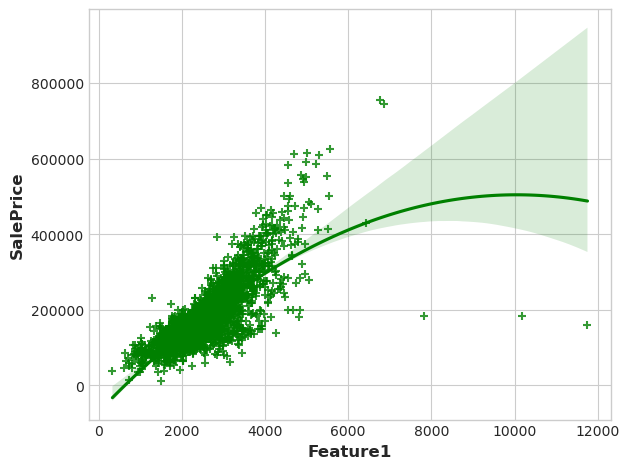

In [6]:
X = df.copy()
y = X.pop("SalePrice")

# YOUR CODE HERE: Add new features to X.
X["Feature1"] = X.GrLivArea + X.TotalBsmtSF
X["Feature2"] = X.YearRemodAdd * X.TotalBsmtSF

Xy = df.copy()
Xy["Feature1"] = Xy.GrLivArea + Xy.TotalBsmtSF
Xy["Feature2"] = Xy.YearRemodAdd * Xy.TotalBsmtSF
sns.regplot(x="Feature1", y='SalePrice', data=Xy, ci=68, order=2,marker="+",color = "g");
# sns.regplot(x="Feature2", y='SalePrice', data=Xy, order=2);

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")


# Solution 2: Uses components
X = df.copy()
y = X.pop("SalePrice")

X = X.join(X_pca)

Xy = df.copy()
Xy = Xy.join(X_pca)
print(Xy.head() )
# sns.regplot(x="Feature1", y='SalePrice', data=Xy, order=2);
# sns.regplot(x="Feature2", y='SalePrice', data=Xy, order=2);


score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")


# Check your answer
q_2.check()

在 sns.regplot 函数中，order 参数表示拟合多项式的阶数。具体来说，order 的值决定了用于拟合数据的多项式的阶数。例如，order=2 表示使用二阶多项式进行拟合，而 order=3 表示使用三阶多项式。

至于你提到的浅绿色背景区域，这部分通常代表拟合曲线的置信区间。具体来说，它表示了拟合曲线的不确定性范围。在回归分析中，置信区间提供了对回归线的估计的不确定性的度量。这个区间通常是由数据的变异性、样本大小和回归模型的复杂性共同决定的。

浅色背景面积较大: 当浅色背景区域较大时，通常表示拟合的不确定性较高。这可能是因为数据中的噪声较多，或者所选的多项式阶数与数据的真实关系不匹配。

颜色: 参数 color="g" 设置了回归线的颜色为绿色。这不会影响浅色背景的颜色。

总体而言，浅色背景提供了关于拟合曲线不确定性的直观表示，有助于了解数据和模型的复杂性。如果你觉得这个置信区间干扰了你的可视化，你可以通过设置 ci=None 来关闭它。

提示：尝试在 X_pca 上使用 make_mi_scores 函数，找出哪些成分可能最有潜力。然后再查看载荷，看看特征之间有哪些关系可能很重要。

或者，您也可以使用成分本身。尝试将 X_pca 中得分最高的成分连接到 X，或者将所有 X_pca 连接到 X。

In [7]:
# Lines below will give you a hint or solution code
q_2.hint()
q_2.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Try using the `make_mi_scores` function on `X_pca` to find out which components might have the most potential. Then look at the loadings to see what kinds of relationships among the features might be important.

Alternatively, you could use the components themselves. Try joining the highest scoring components from `X_pca` to `X`, or just join all of `X_pca` to `X`.


<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> Here are two possible solutions, though you might have been able to find others.
```python
# Solution 1: Inspired by loadings
X = df.copy()
y = X.pop("SalePrice")

X["Feature1"] = X.GrLivArea + X.TotalBsmtSF
X["Feature2"] = X.YearRemodAdd * X.TotalBsmtSF

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")


# Solution 2: Uses components
X = df.copy()
y = X.pop("SalePrice")

X = X.join(X_pca)
score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")
```


-------------------------------------------------------------------------------

The next question explores a way you can use PCA to detect outliers in the dataset (meaning, data points that are unusually extreme in some way). Outliers can have a detrimental effect on model performance, so it's good to be aware of them in case you need to take corrective action. PCA in particular can show you anomalous *variation* which might not be apparent from the original features: neither small houses nor houses with large basements are unusual, but it is unusual for small houses to have large basements. That's the kind of thing a principal component can show you.

Run the next cell to show distribution plots for each of the principal components you created above.

下一个问题将探讨如何使用 PCA 检测数据集中的异常值（即在某些方面异常极端的数据点）。异常值会对模型性能产生不利影响，因此最好能意识到异常值，以便采取纠正措施。特别是 PCA，它可以向您展示从原始特征中可能并不明显的异常变化：小房子和有大地下室的房子都不寻常，但小房子有大地下室是不寻常的。这就是主成分所能显示的。

运行下一个单元格，显示上文创建的每个主成分的分布图。

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


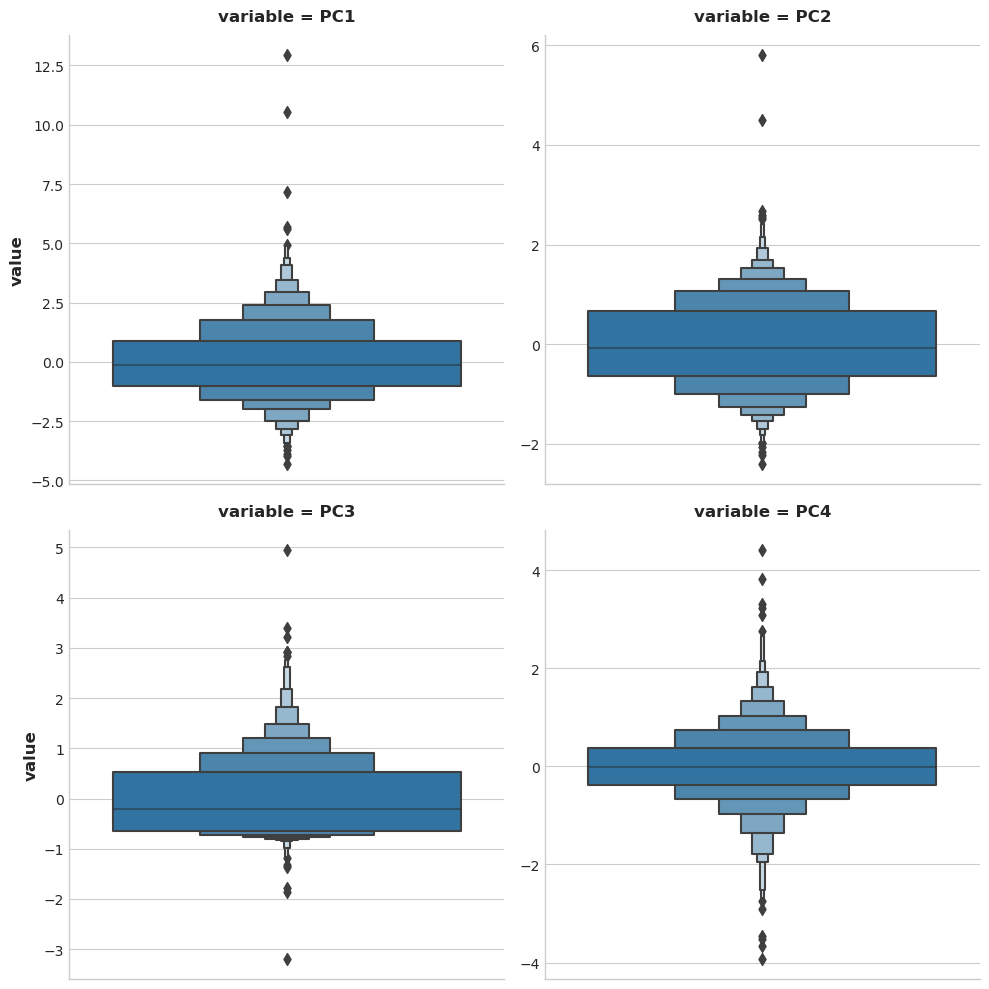

In [8]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

As you can see, in each of the components there are several points lying at the extreme ends of the distributions -- outliers, that is.

Now run the next cell to see those houses that sit at the extremes of a component:

正如您所看到的，在每个组成部分中，都有几个点位于分布的极端--即异常值。

现在运行下一个单元格，查看那些位于成分极值的房屋：

In [9]:
# You can change PC1 to PC2, PC3, or PC4
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1760,745000,Northridge,Abnorml,813.0,1996,2396.0,4476.0
1767,755000,Northridge,Normal,832.0,1995,2444.0,4316.0
...,...,...,...,...,...,...,...
662,59000,Old_Town,Normal,0.0,1950,416.0,599.0
2679,80500,Brookside,Normal,0.0,1950,0.0,912.0
2879,51689,Iowa_DOT_and_Rail_Road,Abnorml,0.0,1950,0.0,729.0
780,63900,Sawyer,Normal,0.0,1950,0.0,660.0


# 3) Outlier Detection

Do you notice any patterns in the extreme values? Does it seem like the outliers are coming from some special subset of the data?

After you've thought about your answer, run the next cell for the solution and some discussion.

3) 异常值检测
您是否注意到极端值中的任何模式？离群值是否来自数据的某个特殊子集？

思考答案后，运行下一个单元格，了解解决方案并进行讨论。

In [10]:
# View the solution (Run this cell to receive credit!)
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Notice that there are several dwellings listed as `Partial` sales in the `Edwards` neighborhood that stand out. A partial sale is what occurs when there are multiple owners of a property and one or more of them sell their "partial" ownership of the property.

These kinds of sales are often happen during the settlement of a family estate or the dissolution of a business and aren't advertised publicly. If you were trying to predict the value of a house on the open market, you would probably be justified in removing sales like these from your dataset -- they are truly outliers.


请注意，在爱德华兹社区，有几处列为部分出售的住宅非常引人注目。部分出售是指房产有多个所有者，其中一个或多个所有者出售其 "部分 "房产所有权。

这类出售通常发生在家庭财产清算或企业解散期间，不会公开发布广告。如果你想预测公开市场上房屋的价值，你可能有理由从数据集中剔除这样的销售--它们确实是异常值。

处理异常值是数据预处理的重要步骤，特别是在构建预测模型时。异常值可能会扭曲模型的参数估计，从而降低预测的准确性。以下是一些常用的处理异常值的方法：

### 删除异常值:
如果你确定某些观测值是真正的异常值，可以选择直接删除它们。

```python
# 删除特定条件下的异常值
df = df.drop(idx)
```
### 使用中位数或均值填充:
你可以选择使用中位数或均值来替换异常值，这种方法对于包含噪声的数据集可能更为稳健。

```python
# 使用中位数填充特定的异常值
median = df['SalePrice'].median()
df.loc[idx, 'SalePrice'] = median
```
### 使用数据转换:
对数据应用某些转换，如对数转换，可能会减轻异常值的影响。

```python
df['SalePrice'] = np.log1p(df['SalePrice'])
```
### 使用机器学习算法处理异常值:
有些机器学习算法，如随机森林和梯度提升，对异常值不太敏感。你可以考虑使用这些算法，或者使用诸如`HuberRegressor`之类的鲁棒回归算法。

### 使用分位数截断:
你可以确定一个阈值，比如上下分位数，然后截断或替换超出这些阈值的值。

```python
lower_bound = df['SalePrice'].quantile(0.05)
upper_bound = df['SalePrice'].quantile(0.95)
df['SalePrice'] = np.clip(df['SalePrice'], lower_bound, upper_bound)
```
### 域知识分析:
根据你对数据的理解和分析，你可能会找到特定的业务逻辑来处理异常值。例如，你提到的部分销售，可以根据具体情况选择删除或者特殊处理。

选择哪种方法取决于数据的性质、异常值的数量以及业务背景。在处理异常值之前，进行详细的探索性数据分析（EDA）以理解数据的分布和异常值的性质是非常重要的。

In [11]:
# You can change PC1 to PC2, PC3, or PC4
component = "PC3"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]


,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1497,284700,Edwards,Normal,624.0,1996,0.0,3820.0
290,160000,South_and_West_of_Iowa_State_University,Normal,0.0,1967,0.0,2650.0
1537,381000,Crawford,Normal,1014.0,1997,728.0,3447.0
2666,475000,Old_Town,Normal,840.0,1993,1107.0,3608.0
2230,315000,Crawford,Normal,691.0,1986,279.0,2726.0
...,...,...,...,...,...,...,...
1656,170000,Northwest_Ames,Normal,944.0,1971,1625.0,1220.0
1637,591587,Stone_Brook,Partial,1110.0,2007,2660.0,2338.0
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
423,555000,Northridge_Heights,Normal,672.0,2008,3094.0,2402.0


Your score: 0.02785 RMSLE
要删除的索引: Int64Index([241, 1498, 2177, 2180, 2181, 2826, 2827], dtype='int64')
----------删除之后----------
Your score: 0.13572 RMSLE


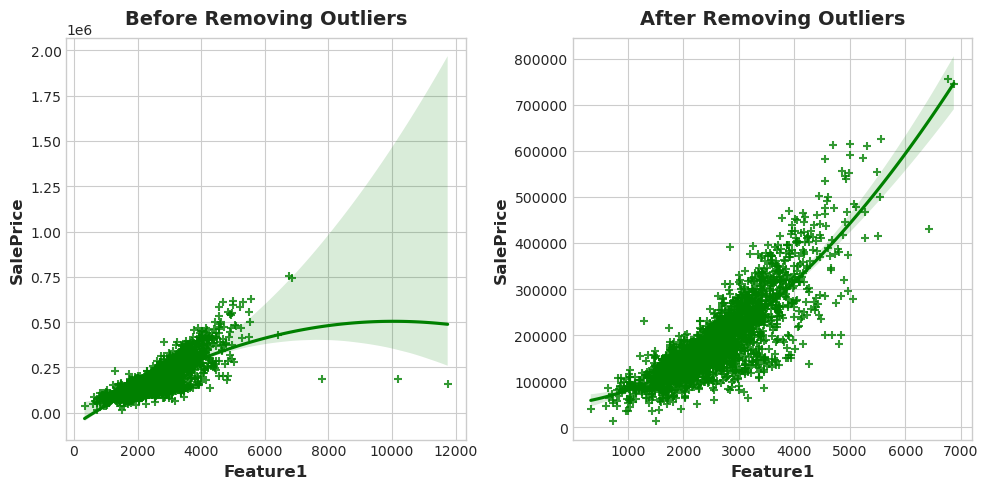

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

Xy["Feature1"] = Xy.GrLivArea + Xy.TotalBsmtSF
Xy["Feature2"] = Xy.YearRemodAdd * Xy.TotalBsmtSF
# print(Xy) # [2930 rows x 85 columns]

# 假设您已经创建了新特征 "Feature1"
# 在删除异常值之前可视化
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.regplot(x="Feature1", y='SalePrice', data=Xy, order=2, marker="+", color="g")
plt.title('Before Removing Outliers')

score = score_dataset(Xy, y)
print(f"Your score: {score:.5f} RMSLE")


# 删除异常值
# 找到在"Edwards"地区且销售条件为"Partial"的房屋索引
outliers_idx = df[(df['Neighborhood'] == 'Edwards') & (df['SaleCondition'] == 'Partial')].index
print("要删除的索引:", outliers_idx)

# 在Xy中删除这些异常值
Xy = Xy.drop(outliers_idx)
print("-"*10 + "删除之后"+ "-"*10)
# print(Xy) # [2923 rows x 85 columns]

# 在删除异常值之后可视化
plt.subplot(1, 2, 2)
sns.regplot(x="Feature1", y='SalePrice', data=Xy, order=2, marker="+", color="g")
plt.title('After Removing Outliers')


Xy_y = Xy.pop("SalePrice")
score = score_dataset(Xy, Xy_y)
print(f"Your score: {score:.5f} RMSLE")

plt.tight_layout()
plt.show()


# Keep Going #

[**Apply target encoding**](https://www.kaggle.com/ryanholbrook/target-encoding) to give a boost to categorical features.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*